In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite", echo=False)

In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

In [10]:
inspector = inspect(engine)
columns = inspector.get_columns('measurement')
for c in columns:
    print(c['name'], c['type'])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [11]:
inspector = inspect(engine)
columns = inspector.get_columns('station')
for c in columns:
    print(c['name'], c['type'])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


### Precipitation Analysis

Last Date in Database: 2017-08-23
Query Start Date (1 Year): 2016-08-23 00:00:00


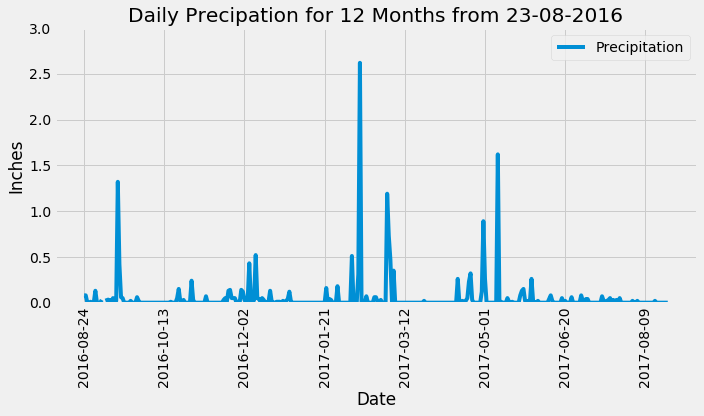

In [12]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results

# Calculate the date 1 year ago from the last data point in the database

# Find last date in database
last_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
last_date, = last_date # Convert object to string
# Calculate the date 1 year ago using strptime() to convert from string to datetime object then using timedelta() to calculate the difference
year_ago = dt.datetime.strptime(last_date, '%Y-%m-%d') - dt.timedelta(days=365)
print(f"Last Date in Database: {last_date}")
print(f"Query Start Date (1 Year): {year_ago}")

# Perform a query to retrieve the data and precipitation scores
precipitation_scores = session.query(Measurement.date, Measurement.prcp)\
                                    .filter(Measurement.date >= year_ago)\
                                    .group_by(Measurement.date).all()

# Save the query results as a Pandas DataFrame and set the index to the date column
prcp_df = pd.DataFrame(precipitation_scores)
prcp_df = prcp_df.set_index("date")

# Sort the dataframe by date
prcp_df = prcp_df.sort_values("date")

# Use Pandas Plotting with Matplotlib to plot the data
fig, ax = plt.subplots(figsize=(10,6), tight_layout=True)
precipitation_plot = prcp_df.plot(ax=ax, title="Daily Precipation for 12 Months from 23-08-2016")
precipitation_plot.set_xlabel("Date")
precipitation_plot.set_ylabel("Inches")
precipitation_plot.legend(["Precipitation"])
plt.xticks(rotation=90)
plt.ylim(0,3)
plt.savefig("output/prcp.png")
plt.show()

In [13]:
# Use Pandas to calculate the summary statistics for the precipitation data
prcp_df.describe()

,prcp
count,363.000000
mean,0.048843
std,0.205197
min,0.000000
25%,0.000000
50%,0.000000
75%,0.020000
max,2.620000


### Station Analysis

In [14]:
# Design a query to show how many stations are available in this dataset?
station_count = session.query(Measurement.station)\
                .group_by(Measurement.station).count()
print(f"There are {station_count} stations in this dataset")

There are 9 stations in this dataset


In [15]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
station_activity = session.query(Measurement.station, func.count(Measurement.station))\
                    .group_by(Measurement.station)\
                    .order_by(func.count(Measurement.station).desc())

for row in station_activity:
    print(row)

print(f"The most active station is {station_activity[0][0]}")

('USC00519281', 2772)
('USC00519397', 2724)
('USC00513117', 2709)
('USC00519523', 2669)
('USC00516128', 2612)
('USC00514830', 2202)
('USC00511918', 1979)
('USC00517948', 1372)
('USC00518838', 511)
The most active station is USC00519281


In [16]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?
(lo,hi,av), = session.query(func.min(Measurement.tobs)\
                                        ,func.max(Measurement.tobs)\
                                        ,func.avg(Measurement.tobs))\
                                        .filter(Measurement.station == \
                                                station_activity[0][0]).all()

print(f"Temperature Observation Data for station {station_activity[0][0]}:\n\
{'-'*53}\n\
Lowest temperature recorded: {lo} F\n\
Highest temperature recorded: {hi} F\n\
Average temperature recorded: {round(av,1)} F")

Temperature Observation Data for station USC00519281:
-----------------------------------------------------
Lowest temperature recorded: 54.0 F
Highest temperature recorded: 85.0 F
Average temperature recorded: 71.7 F


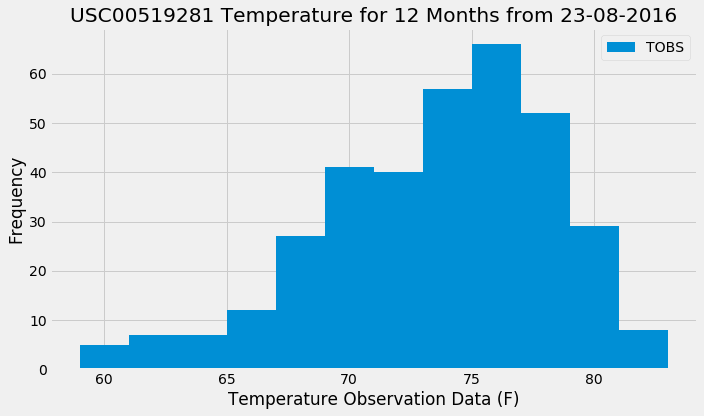

In [17]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
tobs_most_active_station = session.query(Measurement.date, Measurement.tobs)\
            .filter(Measurement.station == station_activity[0][0])\
            .filter(Measurement.date >= year_ago)\
            .all()

tobs_df = pd.DataFrame(tobs_most_active_station)
tobs_df = tobs_df.set_index("date")

fig, ax = plt.subplots(figsize=(10,6), tight_layout=True)
histogram = tobs_df.plot(ax=ax, kind="hist", bins=12, title=f"{station_activity[0][0]} Temperature for 12 Months from 23-08-2016")
histogram.set_xlabel("Temperature Observation Data (F)")
histogram.legend(["TOBS"])
plt.savefig("output/tobs.png")
plt.show()

## Bonus Challenge Assignment

### Temperature Analysis I

In [18]:
# Identify the average temperature in June at all stations across all available years in the dataset.
# Do the same for December temperature

def month_avg_temps(month, month_string):   # Define my own function since will be querying 2 months
    """TAVG for a specific month.
    
    Args:
        month (string): A month string in the format %m
        
    Returns:
        TAVE
    """
    
    monthly_avg_temp, = session.query(func.avg(Measurement.tobs))\
            .filter(func.strftime("%m", Measurement.date) == month).all()
    
    return print(f"Average temperature in {month_string} is {round(monthly_avg_temp[0],1)} F")

month_avg_temps("06", "June")
month_avg_temps("12", "December")

Average temperature in June is 74.9 F
Average temperature in December is 71.0 F


### Temperature Analysis II

In [19]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [20]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
vacation_start_date_LY = dt.date(2016,12,26)
vacation_duration = 15
vacation_end_date_LY = vacation_start_date_LY + dt.timedelta(days=vacation_duration)
(tmin, tave, tmax), = calc_temps(vacation_start_date_LY, vacation_end_date_LY)

print("Temperature analysis of proposed vacation dates (same dates last year)")
print(f"{vacation_duration} days from {vacation_start_date_LY} to {vacation_end_date_LY}")
print("-"*70)
print(f"Minimum temperature during the period: {tmin} F")
print(f"Maximum temperature during the period: {tmax} F")
print(f"Average temperature during the period: {round(tave,1)} F")

Temperature analysis of proposed vacation dates (same dates last year)
15 days from 2016-12-26 to 2017-01-10
----------------------------------------------------------------------
Minimum temperature during the period: 60.0 F
Maximum temperature during the period: 77.0 F
Average temperature during the period: 69.3 F


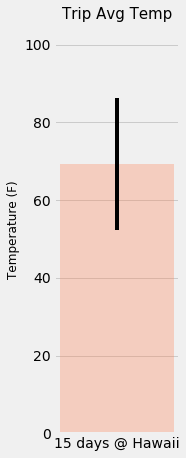

In [21]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
fig, ax = plt.subplots(figsize=(2,7))
bar_plot = ax.bar(f"{vacation_duration} days @ Hawaii", tave, yerr=tmax-tmin, alpha=0.3, color="coral")
plt.title("Trip Avg Temp", fontsize=15)
plt.ylabel("Temperature (F)", fontsize=12)
plt.ylim(0,105)
plt.grid(axis="x")
plt.savefig("output/trip_avg_temp.png")
plt.show()

### Daily Rainfall Average

In [22]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation

from sqlalchemy.ext.automap import automap_base # Import map to map between 2 tables

sel = [Measurement.station, Station.name, Station.latitude, Station.longitude, Station.elevation, func.sum(Measurement.prcp)]

statement_rainfall_avg = session.query(*sel)\
                        .join(Station, Measurement.station==Station.station)\
                        .filter(Measurement.date >= vacation_start_date_LY)\
                        .filter(Measurement.date <= vacation_end_date_LY)\
                        .group_by(Measurement.station)\
                        .order_by(func.sum(Measurement.prcp).desc()).statement

# Read the query directly into a Pandas dataframe
rainfall_avg_df = pd.read_sql_query(statement_rainfall_avg, session.bind)
rainfall_avg_df = rainfall_avg_df.rename(columns={"sum_1":"avg rainfall (inches)"})
rainfall_avg_df = rainfall_avg_df.set_index("station")
rainfall_avg_df

,name,latitude,longitude,elevation,avg rainfall (inches)
station,,,,,
USC00516128,"MANOA LYON ARBO 785.2, HI US",21.33310,-157.80250,152.4,6.69
USC00514830,"KUALOA RANCH HEADQUARTERS 886.9, HI US",21.52130,-157.83740,7.0,1.87
USC00513117,"KANEOHE 838.1, HI US",21.42340,-157.80150,14.6,1.74
USC00519281,"WAIHEE 837.5, HI US",21.45167,-157.84889,32.9,1.62
USC00519523,"WAIMANALO EXPERIMENTAL FARM, HI US",21.33556,-157.71139,19.5,0.85
USC00519397,"WAIKIKI 717.2, HI US",21.27160,-157.81680,3.0,0.21
USC00517948,"PEARL CITY, HI US",21.39340,-157.97510,11.9,NaN


In [23]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [24]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

normals = list() # Create a list for the loop

# Set the start and end date of the trip
vacation_start_date = vacation_start_date_LY + dt.timedelta(days=365)
vacation_end_date = vacation_end_date_LY + dt.timedelta(days=365)

print(f"Proposed vacation dates from {vacation_start_date} to {vacation_end_date}")

# Use the start and end date to create a range of dates
date_range = list() # Create a list to hold range of dates
x = 0 # Create variable for iteration in loop

for x in range(vacation_duration+1):
    date_range.append(vacation_start_date + dt.timedelta(days=x))

# Stip off the year and save a list of %m-%d strings
date_string = list() # Create a list to hold range of dates
i = 0 # Create variable for iteration in loop

for i in range(len(date_range)):
    date_string.append(date_range[i].strftime("%m-%d"))

# Loop through the list of %m-%d strings and calculate the normals for each date
y = 0 # Create variable for iteration in loop

for y in range(len(date_string)):
    normals.append(daily_normals(date_string[y]))
    
print(f"Daily normals calculated using function for vacation dates with {len(normals)} results stored in list")

Proposed vacation dates from 2017-12-26 to 2018-01-10
Daily normals calculated using function for vacation dates with 16 results stored in list


In [25]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index
trip_df = pd.DataFrame(normals)
trip_df = trip_df.rename(columns={0:"normals"})
trip_df["date"] = date_range # Add date range from earlier list
trip_df["min tobs"], trip_df["avg tobs"], trip_df["max tobs"] = zip(*trip_df.normals) # Split out the tuples into separate columns
del trip_df["normals"] # Drop redundant column
trip_df = trip_df.set_index("date") # Set date as index
trip_df

,min tobs,avg tobs,max tobs
date,,,
2017-12-26,63.0,71.446809,77.0
2017-12-27,62.0,71.916667,79.0
2017-12-28,62.0,70.520833,77.0
2017-12-29,57.0,70.291667,78.0
2017-12-30,63.0,69.863636,76.0
2017-12-31,56.0,68.279070,77.0
2018-01-01,62.0,69.153846,77.0
2018-01-02,60.0,69.396226,77.0
2018-01-03,62.0,68.909091,77.0


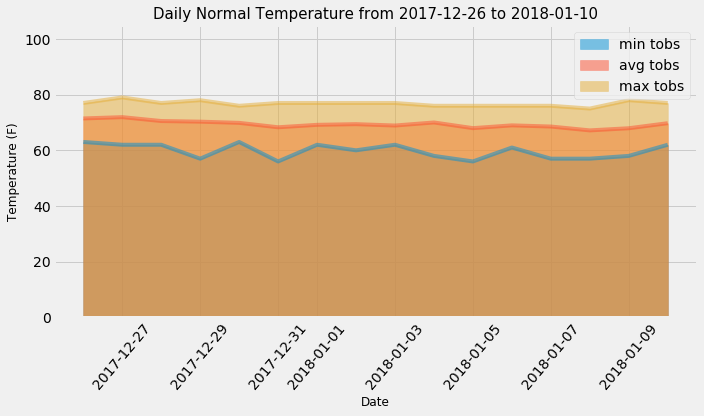

In [26]:
# Plot the daily normals as an area plot with `stacked=False`
fig, ax = plt.subplots(figsize=(10,6), tight_layout=True)
area_plot = trip_df.plot(ax=ax, kind="area", stacked=False)
plt.title(f"Daily Normal Temperature from {vacation_start_date} to {vacation_end_date}", fontsize=15)
plt.ylabel("Temperature (F)", fontsize=12)
plt.xlabel("Date", fontsize=12)
plt.xticks(rotation=50)
plt.ylim(0,105)
plt.savefig("output/daily_normals.png")
plt.show()